In [1]:
!pip install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.2
    Uninstalling torchtext-0.16.2:
      Successfully uninstalled torchtext-0.16.2


In [2]:
!pip install dill

In [3]:
import torchtext
print(torchtext.__version__)

0.6.0


In [4]:
import torch
from torch import nn, optim
from torch.optim import Adam
import torch.utils.data as data
import math
from collections import Counter
import numpy as np
import copy
import time
import spacy
import re
from torchtext import data
import pandas as pd
from torch.autograd import Variable
import dill as pickle
import spacy
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score
import os
import nltk

In [5]:
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Modeling

In [6]:
class Embedder(nn.Module):
  def __init__(self, vocab_size, model_dim):
    super(Embedder, self).__init__()
    self.vocab_size = vocab_size
    self.model = model_dim

    self.embed = nn.Embedding(vocab_size, model_dim)

  def forward(self, x):
    return self.embed(x)

Embedder(100, 512)(torch.LongTensor([1,2,3,4])).shape


torch.Size([4, 512])

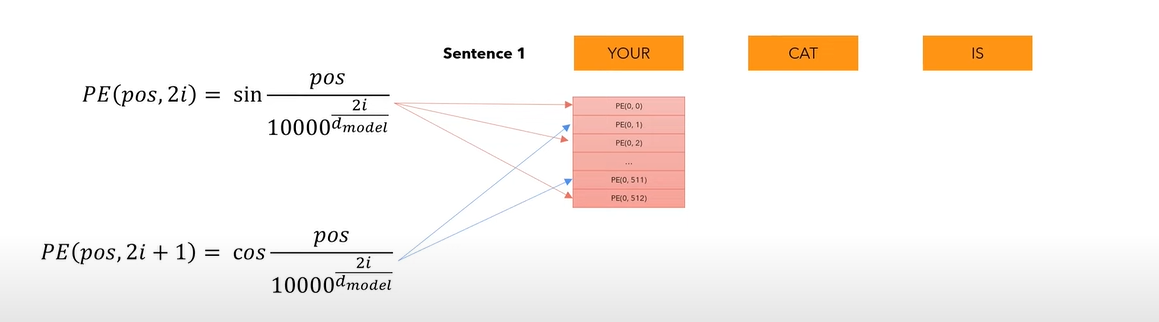

In [7]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_length=200, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_seq_length, d_model)

        for pos in range(max_seq_length):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):

      x = x*math.sqrt(self.d_model)
      seq_length = x.size(1)

      pe = Variable(self.pe[:, :seq_length], requires_grad=False)

      if x.is_cuda:
          pe.cuda()
      x = x + pe
      x = self.dropout(x)

      return x

PositionalEncoder(512)(torch.rand(5, 30, 512)).shape

torch.Size([5, 30, 512])

In [8]:
def attention(q, k, v, mask=None, dropout=None):

    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask==0, -1e9)
    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output, scores

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        assert d_model % heads == 0

        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.attn = None

        # tạo ra 3 ma trận trọng số là q_linear, k_linear, v_linear
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        q: [batch_size, seq_length, d_model]
        k: [batch_size, seq_length, d_model]
        v: [batch_size, seq_length, d_model]
        mask: [batch_size, 1, seq_length]
        output: [batch_size, seq_length, d_model]
        """
        bs = q.size(0)

        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        scores, self.attn = attention(q, k, v, mask, self.dropout)

        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        output = self.out(concat)
        return output



In [10]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model

        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()

        # set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):

        x2 = self.norm_1(x)
        # calculate attention value
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        """
        x: [batch_siz, seq_length, d_model]
        e_outputs: [batch_siz, seq_length, d_model]
        src_mask: [batch_size, 1, seq_length]
        trg_mask: [batch_size, 1, seq_length]
        """
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)

        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

In [13]:
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, src, mask):
        """
        src: [batch_size, seq_length]
        mask: [batch_size, 1, seq_length]
        output: [batch_size, seq_length, d_model]
        """
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embedding = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        """
        trg: [batch_size, seq_length]
        e_outputs: [batch_size, seq_length, d_model]
        src_mask: [batch_size, 1, seq_length]
        trg_mask: [batch_size, 1, seq_length]
        output: [batch_size, seq_length, d_model]
        """
        x = self.embedding(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [14]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        """
        src: [batch_size, seq_length]
        trg: [batch_size, seq_length]
        src_mask: [batch_size, 1, seq_length]
        trg_mask: [batch_size, 1, seq_length]
        output: [batch_size, seq_length, d_model]
        """
        e_outputs = self.encoder(src, src_mask)

        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

# Data

In [15]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)

        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

def nopeak_mask(size, device):
    np_mask = np.triu(np.ones((1, size, size)),
    k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0)
    np_mask = np_mask.to(device)

    return np_mask

def create_masks(src, trg, src_pad, trg_pad, device):
    src_mask = (src != src_pad).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != trg_pad).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size, device)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask

    else:
        trg_mask = None
    return src_mask, trg_mask

def get_synonym(word, SRC):
    syns = wordnet.synsets(word)
    for s in syns:
        for l in s.lemmas():
            if SRC.vocab.stoi[l.name()] != 0:
                return SRC.vocab.stoi[l.name()]

    return 0

def multiple_replace(dict, text):
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)
def init_vars(src, model, SRC, TRG, device, k, max_len):
    init_tok = TRG.vocab.stoi['<sos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)

    e_output = model.encoder(src, src_mask)

    outputs = torch.LongTensor([[init_tok]])

    outputs = outputs.to(device)

    trg_mask = nopeak_mask(1, device)
    out = model.out(model.decoder(outputs,
    e_output, src_mask, trg_mask))
    out = F.softmax(out, dim=-1)

    probs, ix = out[:, -1].data.topk(k)
    log_scores = torch.Tensor([math.log(prob) for prob in probs.data[0]]).unsqueeze(0)

    outputs = torch.zeros(k, max_len).long()
    outputs = outputs.to(device)
    outputs[:, 0] = init_tok
    outputs[:, 1] = ix[0]

    e_outputs = torch.zeros(k, e_output.size(-2),e_output.size(-1))

    e_outputs = e_outputs.to(device)
    e_outputs[:, :] = e_output[0]

    return outputs, e_outputs, log_scores

def k_best_outputs(outputs, out, log_scores, i, k):

    probs, ix = out[:, -1].data.topk(k)
    log_probs = torch.Tensor([math.log(p) for p in probs.data.view(-1)]).view(k, -1) + log_scores.transpose(0,1)
    k_probs, k_ix = log_probs.view(-1).topk(k)

    row = k_ix // k
    col = k_ix % k

    outputs[:, :i] = outputs[row, :i]
    outputs[:, i] = ix[row, col]

    log_scores = k_probs.unsqueeze(0)

    return outputs, log_scores

def beam_search(src, model, SRC, TRG, device, k, max_len):

    outputs, e_outputs, log_scores = init_vars(src, model, SRC, TRG, device, k, max_len)
    eos_tok = TRG.vocab.stoi['<eos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)
    ind = None
    for i in range(2, max_len):

        trg_mask = nopeak_mask(i, device)

        out = model.out(model.decoder(outputs[:,:i],
        e_outputs, src_mask, trg_mask))

        out = F.softmax(out, dim=-1)

        outputs, log_scores = k_best_outputs(outputs, out, log_scores, i, k)

        ones = (outputs==eos_tok).nonzero()
        sentence_lengths = torch.zeros(len(outputs), dtype=torch.long).cuda()
        for vec in ones:
            i = vec[0]
            if sentence_lengths[i]==0:
                sentence_lengths[i] = vec[1]

        num_finished_sentences = len([s for s in sentence_lengths if s > 0])

        if num_finished_sentences == k:
            alpha = 0.7
            div = 1/(sentence_lengths.type_as(log_scores)**alpha)
            _, ind = torch.max(log_scores * div, 1)
            ind = ind.data[0]
            break

    if ind is None:

        length = (outputs[0]==eos_tok).nonzero()[0] if len((outputs[0]==eos_tok).nonzero()) > 0 else -1
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[0][1:length]])

    else:
        length = (outputs[ind]==eos_tok).nonzero()[0]
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[ind][1:length]])
def translate_sentence(sentence, model, SRC, TRG, device, k, max_len):
    model.eval()
    indexed = []
    sentence = SRC.preprocess(sentence)

    for tok in sentence:
        if SRC.vocab.stoi[tok] != SRC.vocab.stoi['<eos>']:
            indexed.append(SRC.vocab.stoi[tok])
        else:
            indexed.append(get_synonym(tok, SRC))

    sentence = Variable(torch.LongTensor([indexed]))

    sentence = sentence.to(device)

    sentence = beam_search(sentence, model, SRC, TRG, device, k, max_len)

    return  multiple_replace({' ?' : '?',' !':'!',' .':'.','\' ':'\'',' ,':','}, sentence)

In [16]:
class tokenize(object):

    def __init__(self, lang):
        self.nlp = spacy.load(lang)

    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok.text for tok in self.nlp.tokenizer(sentence) if tok.text != " "]

In [17]:
def read_data(src_file, trg_file):
    src_data = open(src_file).read().strip().split('\n')

    trg_data = open(trg_file).read().strip().split('\n')

    return src_data, trg_data

def create_fields(src_lang, trg_lang):

    print("loading spacy tokenizers...")

    t_src = tokenize(src_lang)
    t_trg = tokenize(trg_lang)

    TRG = data.Field(lower=True, tokenize=t_trg.tokenizer, init_token='<sos>', eos_token='<eos>')
    SRC = data.Field(lower=True, tokenize=t_src.tokenizer)

    return SRC, TRG

def create_dataset(src_data, trg_data, max_strlen, batchsize, device, SRC, TRG, istrain=True):

    print("creating dataset and iterator... ")

    raw_data = {'src' : [line for line in src_data], 'trg': [line for line in trg_data]}
    df = pd.DataFrame(raw_data, columns=["src", "trg"])

    mask = (df['src'].str.count(' ') < max_strlen) & (df['trg'].str.count(' ') < max_strlen)
    df = df.loc[mask]

    df.to_csv("translate_transformer_temp.csv", index=False)

    data_fields = [('src', SRC), ('trg', TRG)]
    train = data.TabularDataset('./translate_transformer_temp.csv', format='csv', fields=data_fields)

    train_iter = MyIterator(train, batch_size=batchsize, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=istrain, shuffle=True)

    os.remove('translate_transformer_temp.csv')

    if istrain:
        SRC.build_vocab(train)
        TRG.build_vocab(train)

    return train_iter
def step(model, optimizer,batch, criterion):
    model.train()

    src = batch.src.transpose(0,1).cuda()
    trg = batch.trg.transpose(0,1).cuda()
    trg_input = trg[:, :-1]
    src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, 'cuda')
    preds = model(src, trg_input, src_mask, trg_mask)

    ys = trg[:, 1:].contiguous().view(-1)

    optimizer.zero_grad()
    loss = criterion(preds.view(-1, preds.size(-1)), ys)
    loss.backward()
    optimizer.step()

    loss = loss.item()

    return loss
def validate(model, valid_iter, criterion):
    model.eval()

    with torch.no_grad():
        total_loss = []
        for batch in valid_iter:
            src = batch.src.transpose(0,1).cuda()
            trg = batch.trg.transpose(0,1).cuda()
            trg_input = trg[:, :-1]
            src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, opt['device'])
            preds = model(src, trg_input, src_mask, trg_mask)

            ys = trg[:, 1:].contiguous().view(-1)

            loss = criterion(preds.view(-1, preds.size(-1)), ys)

            loss = loss.item()

            total_loss.append(loss)

    avg_loss = np.mean(total_loss)

    return avg_loss

In [18]:
train_src_data, train_trg_data = read_data('/kaggle/input/dataset-translation/train.en', '/kaggle/input/dataset-translation/train.vi')
val_src, val_trg = read_data('/kaggle/input/dataset-translation/tst2012.en', '/kaggle/input/dataset-translation/tst2012.vi')
test_src, test_trg = read_data('/kaggle/input/dataset-translation/tst2013.en', '/kaggle/input/dataset-translation/tst2013.vi')

In [19]:
len(test_src)

1268

In [20]:

def bleu(valid_src_data, valid_trg_data, model, SRC, TRG, device, k, max_strlen):
    pred_sents = []
    for sentence in valid_src_data:
        pred_trg = translate_sentence(sentence, model, SRC, TRG, device, k, max_strlen)
        pred_sents.append(pred_trg)

    pred_sents = [TRG.preprocess(sent) for sent in pred_sents]
    trg_sents = [[sent.split()] for sent in valid_trg_data]

    return bleu_score(pred_sents, trg_sents)

In [36]:
opt = {
    'valid_src_data':'/kaggle/input/dataset-translation/tst2012.en',
    'valid_trg_data':'/kaggle/input/dataset-translation/tst2012.vi',
    'src_lang':'en',
    'trg_lang':'en',
    'max_strlen':128,
    'batchsize':1500,
    'device':'cuda',
    'd_model': 512,
    'n_layers': 6,
    'heads': 8,
    'dropout': 0.1,
    'lr':0.0001,
    'epochs':30,
    'printevery': 200,
    'k':5,
}

In [37]:
train_src_data, train_trg_data = read_data('/kaggle/input/dataset-translation/train.en', '/kaggle/input/dataset-translation/train.vi')
valid_src_data, valid_trg_data = read_data(opt['valid_src_data'], opt['valid_trg_data'])
SRC, TRG = create_fields('en_core_web_sm', 'en_core_web_sm')
train_iter = create_dataset(train_src_data, train_trg_data, 160, 1500, 'cuda', SRC, TRG, istrain=True)
valid_iter = create_dataset(valid_src_data, valid_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=False)

loading spacy tokenizers...
creating dataset and iterator... 
creating dataset and iterator... 


In [38]:
src_pad = SRC.vocab.stoi['<pad>']
trg_pad = TRG.vocab.stoi['<pad>']

In [39]:
def bleu(valid_src_data, valid_trg_data, model, SRC, TRG, device, k, max_strlen):
    pred_sents = []
    for sentence in valid_src_data:
        pred_trg = translate_sentence(sentence, model, SRC, TRG, device, k, max_strlen)
        pred_sents.append(pred_trg)

    pred_sents = [TRG.preprocess(sent) for sent in pred_sents]
    trg_sents = [[sent.split()] for sent in valid_trg_data]

    return bleu_score(pred_sents, trg_sents)

In [40]:
model = Transformer(len(SRC.vocab), len(TRG.vocab), 512, 6, 8, 0.1)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to('cuda')

In [41]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 86748020


In [42]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)

In [43]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [45]:
for epoch in range(5):
    total_loss = 0

    for i, batch in enumerate(train_iter):
        loss = step(model, optimizer, batch, criterion)

        total_loss += loss

        if (i + 1) % 200 == 1:
            avg_loss = total_loss/200
            print('epoch: {:03d} - iter: {:05d} - train loss: {:.4f}'.format(epoch, i, avg_loss))
            total_loss = 0

    valid_loss = validate(model, valid_iter, criterion)
    bleuscore = bleu(valid_src_data, valid_trg_data, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
    print('epoch: {:03d} - iter: {:05d} - valid loss: {:.4f} - bleu score: {:.4f}'.format(epoch, i, valid_loss, bleuscore))

epoch: 000 - iter: 00000 - train loss: 0.0499
epoch: 000 - iter: 00200 - train loss: 6.1292
epoch: 000 - iter: 00400 - train loss: 5.4431
epoch: 000 - iter: 00600 - train loss: 4.9116
epoch: 000 - iter: 00800 - train loss: 4.6724
epoch: 000 - iter: 01000 - train loss: 4.3991
epoch: 000 - iter: 01200 - train loss: 4.2514
epoch: 000 - iter: 01400 - train loss: 4.1375
epoch: 000 - iter: 01600 - train loss: 4.0369
epoch: 000 - iter: 01800 - train loss: 3.9244
epoch: 000 - iter: 02000 - train loss: 3.7960
epoch: 000 - iter: 02200 - train loss: 3.6968
epoch: 000 - iter: 02400 - train loss: 3.6360
epoch: 000 - iter: 02497 - valid loss: 2.4519 - bleu score: 0.0709
epoch: 001 - iter: 00000 - train loss: 0.0134
epoch: 001 - iter: 00200 - train loss: 3.3771
epoch: 001 - iter: 00400 - train loss: 3.3814
epoch: 001 - iter: 00600 - train loss: 3.2909
epoch: 001 - iter: 00800 - train loss: 3.2622
epoch: 001 - iter: 01000 - train loss: 3.2596
epoch: 001 - iter: 01200 - train loss: 3.1503
epoch: 001 - 

In [46]:
bleu(valid_src_data, valid_trg_data, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
sentence='My family was not poor , and myself , I had never experienced hunger .'
trans_sent = translate_sentence(sentence, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
trans_sent

'gia đình tôi không phải là người nghèo, và tôi chưa bao giờ trải qua đói nghèo.'

In [47]:
sentence='Sometime, I do not feel so good'
trans_sent = translate_sentence(sentence, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
trans_sent

'một lúc nào đó, tôi không cảm thấy tốt lắm.'

In [49]:
sentences = ['I enjoy spending time outdoors, especially when the weather is nice.',
            'The sound of rain hitting the roof is very soothing to me.',
            'Whenever I feel stressed, I like to take a long walk in the park.',
            'The smell of fresh-baked cookies always reminds me of my childhood.']

for sentence in sentences:
  trans_sent = translate_sentence(sentence, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
  print(trans_sent)

tôi tận hưởng thời gian ngoại ô, đặc biệt là khi thời tiết đẹp.
âm thanh của cơn mưa đập vào mái nhà là rất xấu hổ đối với tôi.
bất cứ khi nào tôi cảm thấy căng thẳng, tôi thích đi dạo trong công viên.
mùi thơm của mùi thơm luôn nhắc nhở tôi thời thơ ấu của tôi.
